# First, imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import joblib
import torch
from transformers import DistilBertTokenizer, DistilBertModel
# from sentence_transformers import SentenceTransformer
from torch.cuda.amp import autocast
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from scipy.sparse import save_npz

ModuleNotFoundError: No module named 'wordcloud'

# Second, importing google drive and setting up pandas dataframe.
We first need to convert the .txt into .csv for ease of use in pandas.

In [ ]:
# prompt: Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing kaggle API and using it.

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/APIs/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set appropriate permissions

In [ ]:
!kaggle datasets download bittlingmayer/amazonreviews

Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
100% 493M/493M [00:09<00:00, 65.9MB/s]
100% 493M/493M [00:09<00:00, 57.1MB/s]


In [ ]:
!unzip amazonreviews.zip

Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


In [ ]:
!bzip2 -d test.ft.txt.bz2
!bzip2 -d train.ft.txt.bz2

In [ ]:
!mv test.ft.txt /content/drive/MyDrive/Data-sets/AmazonReviews
!mv train.ft.txt /content/drive/MyDrive/Data-sets/AmazonReviews

Conversion to csv.

In [ ]:
def count_lines(file_path):
  """Count the total number of lines in the file."""
  with open(file_path, 'r') as f:
    return sum(1 for line in f)

def print_progress(current_line, total_lines):
    percentage = (current_line / total_lines) * 100
    if percentage % 10 == 0:
        clear_output(wait=True)
        print(f"Progress: {percentage:.0f}%")

def convert_file(input_file, output_file):
    sentiments = []
    reviews = []

    total_lines = count_lines(input_file)  # Count total lines in the file

    with open(input_file, 'r') as infile:
        for current_line, line in enumerate(infile, start=1):
            parts = line.strip().split(maxsplit=1)  # Split only at the first space
            if len(parts) == 2:
                label, review = parts
                sentiment = 0 if '__label__1' in label else 1 if '__label__2' in label else None
                # 0 is negative and 1 is positive.
                if sentiment is not None:
                    sentiments.append(sentiment)
                    reviews.append(review)

            # Print progress after processing each line
            print_progress(current_line, total_lines)

    # Create a DataFrame
    df = pd.DataFrame({
        'Sentiment': sentiments,
        'Review': reviews
    })

    # Save the DataFrame to a .csv file
    df.to_csv(output_file, index=False)

    print("Conversion completed using pandas!")

# converting train.
input_file = '/content/drive/MyDrive/Data-sets/AmazonReviews/train.ft.txt'
output_file = '/content/drive/MyDrive/Data-sets/AmazonReviews/train.ft.csv'

convert_file(input_file, output_file)

# converting test
input_file = '/content/drive/MyDrive/Data-sets/AmazonReviews/test.ft.txt'
output_file = '/content/drive/MyDrive/Data-sets/AmazonReviews/test.ft.csv'

convert_file(input_file, output_file)

Progress: 100%
Conversion completed using pandas!


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Data-sets/AmazonReviews/train.ft.csv')
line_count = len(df1)

print(f'Number of lines in the CSV: {line_count}')

Number of lines in the CSV: 3600000


In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Data-sets/AmazonReviews/test.ft.csv')
line_count = len(df2)

print(f'Number of lines in the CSV: {line_count}')

Number of lines in the CSV: 400000


# Now, we start the EDA (Exploratory Data Analysis).

In [ ]:
trainingset = df1
print(trainingset.head(20))
print("================================================")
print("<Showing set info>")
print(trainingset.info())
print("================================================")
print("<Showing null values>")
print(trainingset.isnull().sum())
print("================================================")
print("<Showing set description>")
print(trainingset.describe())

    Sentiment                                             Review
0           1  Stuning even for the non-gamer: This sound tra...
1           1  The best soundtrack ever to anything.: I'm rea...
2           1  Amazing!: This soundtrack is my favorite music...
3           1  Excellent Soundtrack: I truly like this soundt...
4           1  Remember, Pull Your Jaw Off The Floor After He...
5           1  an absolute masterpiece: I am quite sure any o...
6           0  Buyer beware: This is a self-published book, a...
7           1  Glorious story: I loved Whisper of the wicked ...
8           1  A FIVE STAR BOOK: I just finished reading Whis...
9           1  Whispers of the Wicked Saints: This was a easy...
10          0  The Worst!: A complete waste of time. Typograp...
11          1  Great book: This was a great book,I just could...
12          1  Great Read: I thought this book was brilliant,...
13          0  Oh please: I guess you have to be a romance no...
14          0  Awful beyo

## Seeing the sentiment distribution.

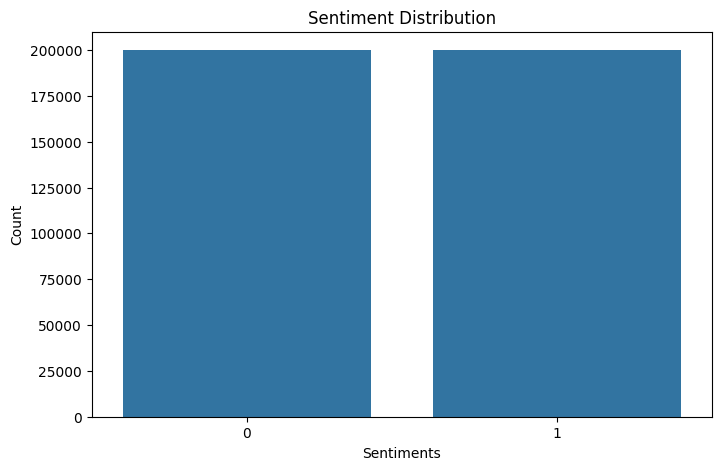

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment', data=df)
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

## Text Length Analysis

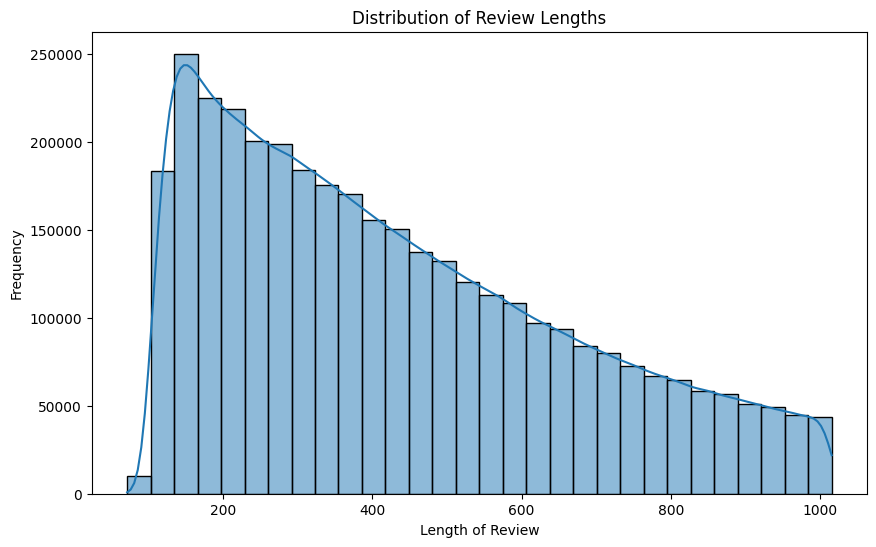

In [ ]:
# Calculate the length of each review
trainingset['review_length'] = trainingset['Review'].apply(len)

# Visualize the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(trainingset['review_length'], bins=30, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.show()

Generate a word cloud to visualize common words in reviews.

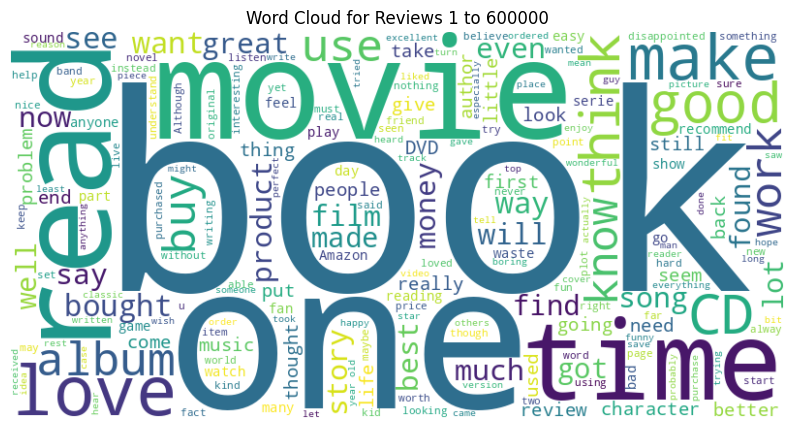

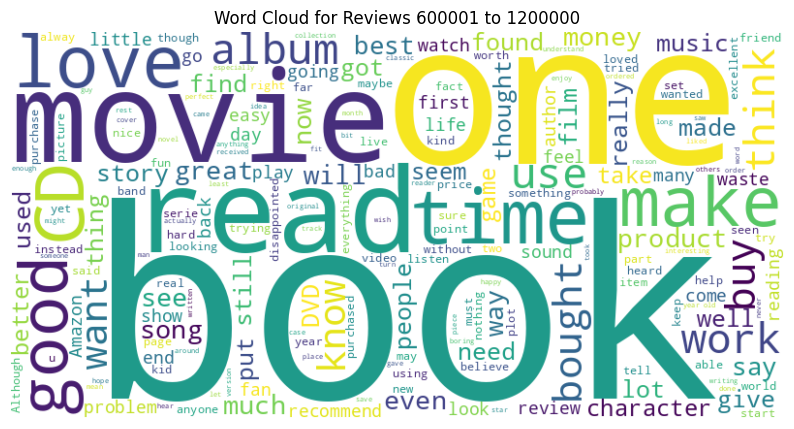

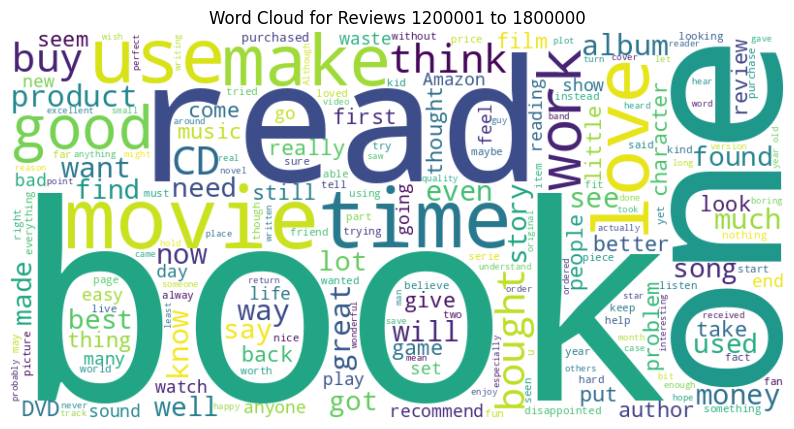

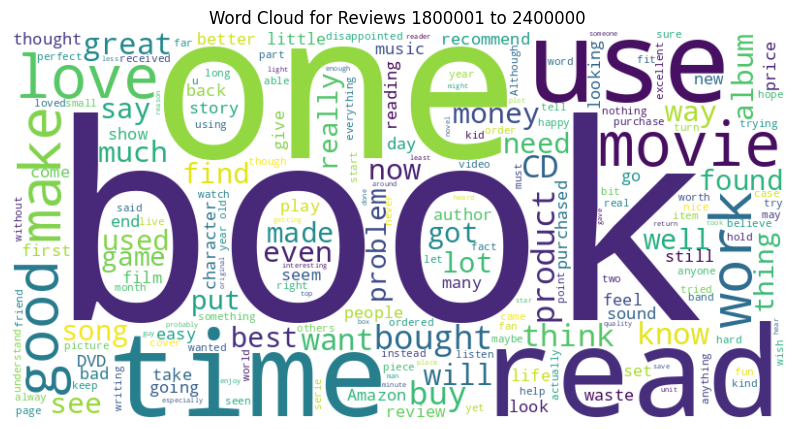

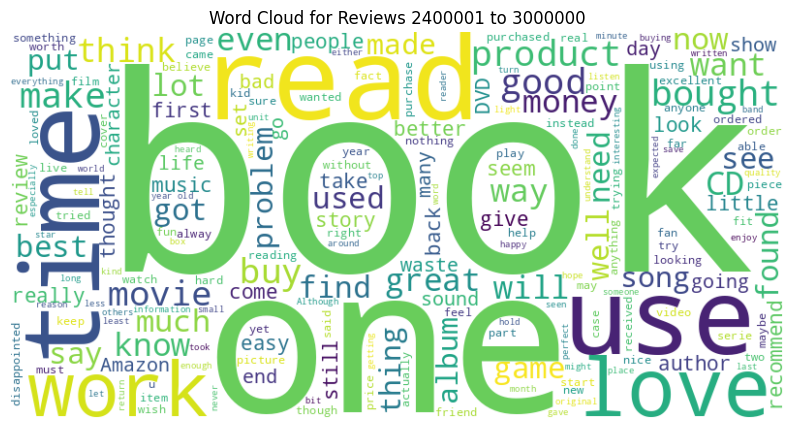

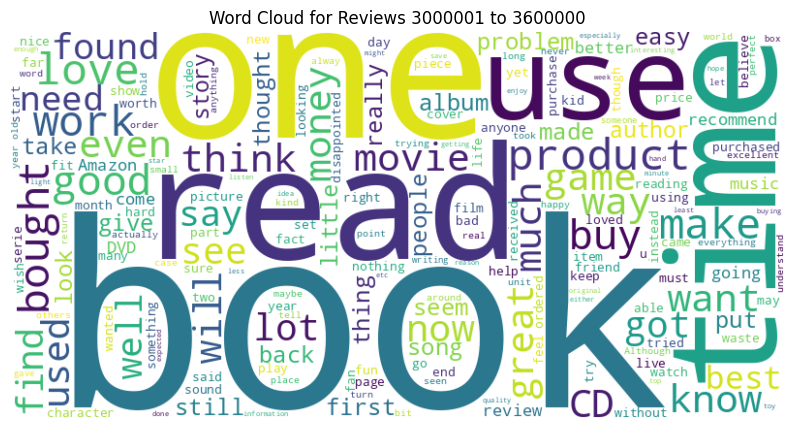

In [ ]:
def generate_word_clouds(trainingset, chunk_size=600000):
    # Generate word clouds in smaller chunks
    for i in range(0, len(trainingset), chunk_size):
        # Combine a batch of reviews into a single string
        chunk_reviews = ' '.join(trainingset['Review'].iloc[i:i + chunk_size])

        # Generate the word cloud for the current chunk
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(chunk_reviews)

        # Display the word cloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Reviews {i + 1} to {min(i + chunk_size, len(trainingset))}')
        plt.show()

generate_word_clouds(trainingset)

Topic modeling

In [ ]:
# Sample a smaller subset of reviews for faster processing
sampled_reviews = trainingset['Review'].sample(n=10000, random_state=1)  # Adjust n as necessary

# Use CountVectorizer with optimized parameters
vectorizer = CountVectorizer(
    max_features=10000,  # Limit the number of features to speed up processing
    stop_words='english',  # Remove common stop words
    lowercase=True  # Convert all text to lowercase
)

# Create the document-term matrix
doc_term_matrix = vectorizer.fit_transform(sampled_reviews)

# Fit LDA with fewer components and iterations for quicker convergence
lda = LatentDirichletAllocation(
    n_components=5,  # Adjust number of topics as needed
    max_iter=10,  # Limit iterations for faster fitting
    learning_method='online',  # Use online learning for efficiency
    batch_size=128,  # Adjust batch size to balance speed and convergence
    random_state=0
)

# Fit the LDA model
lda.fit(doc_term_matrix)

LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=0)

In [ ]:
# Display the top words for each topic
num_top_words = 10  # Adjust the number of top words to display
for idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[-num_top_words:][::-1]  # Get indices of top words
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_indices]  # Retrieve top words
    print(f'Topic {idx + 1}: {", ".join(top_words)}')

Topic 1: cd, album, music, like, songs, great, best, song, good, version
Topic 2: book, read, movie, good, just, like, story, really, great, books
Topic 3: watch, year, old, son, love, loves, like, christmas, guys, just
Topic 4: game, dvd, play, great, fun, video, lost, people, love, way
Topic 5: great, product, good, just, use, bought, buy, like, work, time


N-gram analysis for some deeper insights.

In [ ]:
# Sample a small subset of reviews
sampled_reviews = trainingset['Review'].sample(n=10000, random_state=1)

# Use CountVectorizer with optimized parameters
ngram_vectorizer = CountVectorizer(
    ngram_range=(2, 2),  # For bi-grams
    max_features=10000,  # Limit the number of features
    stop_words='english'  # Remove common stop words
)

# Create the document-term matrix
ngram_matrix = ngram_vectorizer.fit_transform(sampled_reviews)

# Get the sum of bi-grams
ngram_counts = ngram_matrix.sum(axis=0)

# Extract the bi-grams and their frequencies
ngram_freq = [(ngram_vectorizer.get_feature_names_out()[idx], ngram_counts[0, idx]) for idx in range(ngram_counts.shape[1])]
ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:10]

# Print the most common bi-grams
print(ngram_freq)

[('read book', 272), ('waste money', 259), ('year old', 215), ('don know', 168), ('don waste', 159), ('highly recommend', 158), ('waste time', 150), ('book read', 147), ('great book', 136), ('years ago', 128)]


Now that we have explored out our data and gained some insights, we can start with the next step.
# Data pre-processing.

In [ ]:
training = pd.read_csv('/content/drive/MyDrive/Data-sets/AmazonReviews/train.ft.csv')
testing = pd.read_csv('/content/drive/MyDrive/Data-sets/AmazonReviews/test.ft.csv')

Lowercasing, Removing Special Characters, Tokenization, Removing Stop Words, Stemming/Lemmatization, and tokenization.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Remove stop words and lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
training['Processed_Review'] = training['Review'].apply(preprocess_text)

Checking the output

In [ ]:
print(training['Processed_Review'].head(20))

0     stuning even nongamer sound track beautiful pa...
1     best soundtrack ever anything im reading lot r...
2     amazing soundtrack favorite music time hand in...
3     excellent soundtrack truly like soundtrack enj...
4     remember pull jaw floor hearing youve played g...
5     absolute masterpiece quite sure actually takin...
6     buyer beware selfpublished book want know whyr...
7     glorious story loved whisper wicked saint stor...
8     five star book finished reading whisper wicked...
9     whisper wicked saint easy read book made want ...
10    worst complete waste time typographical error ...
11    great book great booki could put downand could...
12    great read thought book brilliant yet realisti...
13    oh please guess romance novel lover one discer...
14    awful beyond belief feel write keep others was...
15    dont try fool u fake review glaringly obvious ...
16    romantic zen baseball comedy hear folk say don...
17    fashionable compression stocking dvt docto

Saving file temporarily.

In [ ]:
training.to_csv('/content/drive/MyDrive/Data-sets/AmazonReviews/preprocessed/training_temp.csv', index=False)

Same process for testing set.

In [ ]:
testing['Processed_Review'] = testing['Review'].apply(preprocess_text)

In [ ]:
print(testing['Processed_Review'].head(20))

0     great cd lovely pat one great voice generation...
1     one best game music soundtrack game didnt real...
2     battery died within year bought charger jul wo...
3     work fine maha energy better check maha energy...
4     great nonaudiophile reviewed quite bit combo p...
5     dvd player crapped one year also began incorre...
6     incorrect disc love style couple year dvd givi...
7     dvd menu select problem scroll dvd menu set ve...
8     unique weird orientalia exotic tale orient dr ...
9     ultimate guide firstlyi enjoyed format tone bo...
10    great book travelling europe currently live eu...
11    want listen el duke better access showerthis g...
12    complete bust game requires quicktime workif b...
13    truly made difference using product couple yea...
14    didnt run usb bus power hoping drive would run...
15    dont buy first company took money sent email t...
16    simple durable fun game age awesome game almos...
17    review kelly club toddler price pc game we

In [ ]:
testing.to_csv('/content/drive/MyDrive/Data-sets/AmazonReviews/preprocessed/testing_temp.csv', index=False)

Extracting the temporary save for future use and shorter retries.

In [ ]:
# This will speed up handling server crashes.
training = pd.read_csv('/content/drive/MyDrive/Data-sets/AmazonReviews/preprocessed/training_temp.csv')
testing = pd.read_csv('/content/drive/MyDrive/Data-sets/AmazonReviews/preprocessed/testing_temp.csv')

Dropping most of the datasets and merging them for later use. This can be ignored when provided with the necessary computational power

In [ ]:
def merge_and_downsample(training_df, testing_df, text_column, label_column, target_size=1000000):
    """
    Merges training and testing datasets, and downsample the data to 1 million entries
    while keeping the number of 0 sentiment and 1 sentiment equal.

    Parameters:
    - training_df: DataFrame of the training data.
    - testing_df: DataFrame of the testing data.
    - text_column: The name of the column containing text data.
    - label_column: The name of the column containing the sentiment labels.
    - target_size: The target number of entries after downsampling (default: 1 million).

    Returns:
    - A DataFrame with 1 million entries, balanced between sentiment 0 and 1.
    """

    # Step 1: Merge the datasets
    combined_df = pd.concat([training_df, testing_df], ignore_index=True)

    # Step 2: Separate the classes
    sentiment_0_df = combined_df[combined_df[label_column] == 0]
    sentiment_1_df = combined_df[combined_df[label_column] == 1]

    # Step 3: Determine the target number of entries per class (assuming we want a balanced dataset)
    target_per_class = target_size // 2  # 500,000 entries for sentiment 0 and 500,000 for sentiment 1

    # Step 4: Downsample each class to the target number
    downsampled_0_df = sentiment_0_df.sample(n=target_per_class, random_state=42)
    downsampled_1_df = sentiment_1_df.sample(n=target_per_class, random_state=42)

    # Step 5: Concatenate the downsampled DataFrames back together
    final_df = pd.concat([downsampled_0_df, downsampled_1_df], ignore_index=True)

    # Shuffle the final DataFrame to mix the 0s and 1s
    final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return final_df

In [ ]:
final_df = merge_and_downsample(training, testing, 'Processed_Review', 'Sentiment', target_size=1000000)

Checking on the output of the pre-process and drop.

In [ ]:
print(final_df.isnull().sum())

Sentiment           0
Review              0
Processed_Review    0
dtype: int64


Weird? but no issue when it's few in numbers.

In [ ]:
final_df.to_csv('/content/drive/MyDrive/Data-sets/AmazonReviews/preprocessed/final_df_temp.csv', index=False)

# Vectorization.

Getting the saved final dataframe.

In [2]:
final_df = pd.read_csv('/home/star/mnt/New Volume D/Courses/DEPI/Projects/Senti-DEPI/data/final_df_temp.csv')

Defining the function for vectorization using huggingface.

In [3]:
def process_and_save_vectorized_data_huggingface(df, text_column, label_column, output_file, model_name='distilbert-base-uncased', batch_size=32):
    """
    Process text data using Hugging Face's transformer models and save the vectorized form and labels to CSV file.

    Parameters:
    - df: DataFrame containing the text data.
    - text_column: The name of the column containing text data.
    - label_column: The name of the column containing labels (e.g., sentiment).
    - output_file: The base name of the output files for vectorized data and labels.
    - model_name: The pre-trained transformer model name from Hugging Face (default: distilbert-base-uncased).
    - batch_size: Batch size for processing data (default: 32).
    """

    # Step 1: Fill NaN values in the text_column with an empty string
    df[text_column] = df[text_column].fillna('').astype(str)  # Ensure all data is of string type

    # Load the tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertModel.from_pretrained(model_name)

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Function to get embeddings
    def get_embeddings(texts):
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the mean of the last hidden states as embeddings
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        return embeddings

    # Process in batches to avoid memory overload
    all_embeddings = []
    for i in tqdm(range(0, len(df), batch_size), desc="Vectorizing Text"):
        batch_texts = df[text_column][i:i+batch_size].tolist()
        embeddings = get_embeddings(batch_texts)
        all_embeddings.append(embeddings)

    # Concatenate all embeddings
    all_embeddings = torch.tensor(all_embeddings).reshape(-1, 768).numpy()

    # Create DataFrame from embeddings and combine with labels
    embeddings_df = pd.DataFrame(all_embeddings)
    labels_df = df[[label_column]].reset_index(drop=True)

    # Combine features and labels
    final_df = pd.concat([labels_df, embeddings_df], axis=1)

    # Save to CSV
    final_df.to_csv(output_file + '.csv', index=False)
    print(f"Data saved to {output_file}.csv")

Using the function.

In [4]:
process_and_save_vectorized_data_huggingface(final_df, 'Processed_Review', 'Sentiment', 'vectorized_data_hf', batch_size=32)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/home/star/venvs/jupyter_venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Vectorizing Text:   1%|▉                                                                      | 417/31250 [07:15<8:57:01,  1.05s/it]


KeyboardInterrupt: 

Save progress for training.